In [1]:
import datetime
import copy


import numpy as np
from numpy.random import normal as rnorm, multinomial as rmultinomial
import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=sm.tools.sm_exceptions.DomainWarning)

In [3]:
data_W = pd.read_excel(r"data/VIMS WQ Data.xlsx", sheet_name = "W", parse_dates=[r"Combine", r"Combined Date", r"MM/DD/YY"],)
data_WW = pd.read_excel(r"data/VIMS WQ Data.xlsx", sheet_name = "WW", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )
#data_WW_2 = pd.read_excel(r"data/2022-Willis_Wharf ALL Raw.xlsx", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )
data_WW_2 = pd.read_excel(r"data/2022-Willis_Wharf ALL Raw (1).xlsx", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )

data_W = data_W.drop(
    columns=["Unnamed: 16", "Unnamed: 18", "Unnamed: 20", "MM/DD/YY.1", "Flagged or Deleted Data Points/Notes",
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "log10 ch", "HH:mm:SS", "Combined Date"]
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Combine": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW = data_WW.drop(
    columns=["Unnamed: 17", "Unnamed: 18", "MM/DD/YY.1", "Flagged or Deleted Data/Notes", "Log10 chl", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)", "Day"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW_2 = data_WW_2.drop(
    columns=["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW = pd.concat([data_WW[data_WW.index.year < 2022], data_WW_2])


## EDA

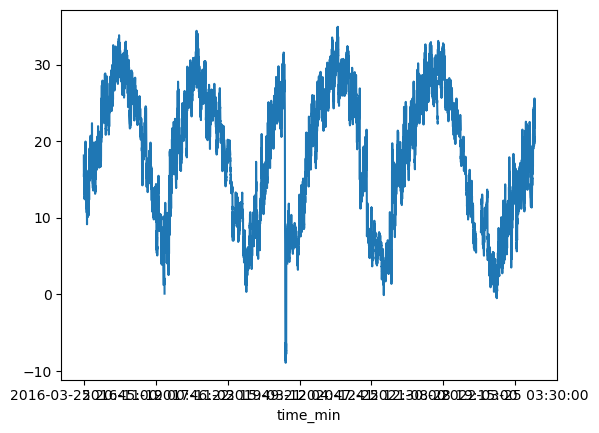

In [74]:
data_W["temperature"].plot()
plt.show()

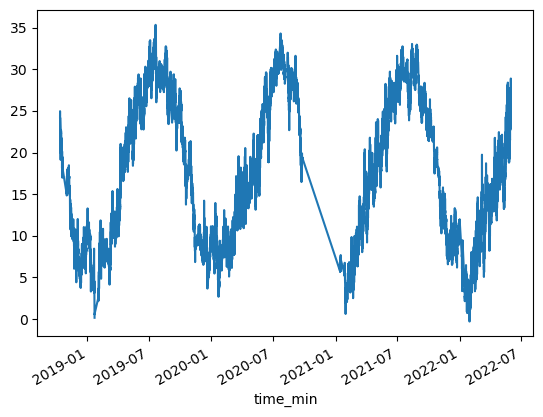

In [75]:
data_WW["temperature"].plot()
plt.show()

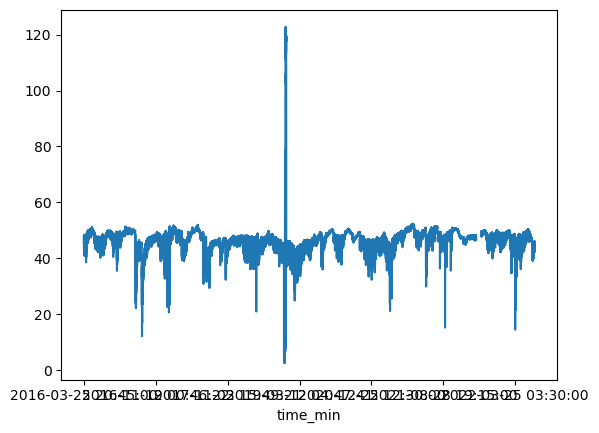

In [76]:
data_W["conductivity"].plot()
plt.show()

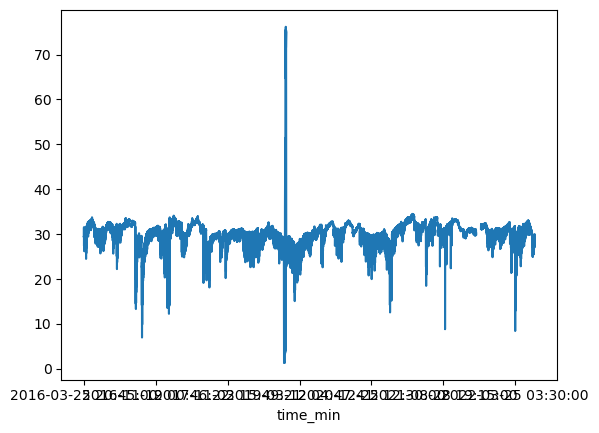

In [77]:
data_W["salinity"].plot()
plt.show()

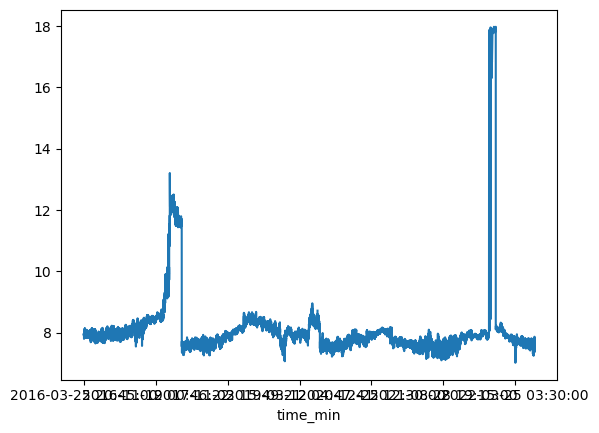

In [78]:
data_W["pH"].plot()
plt.show()

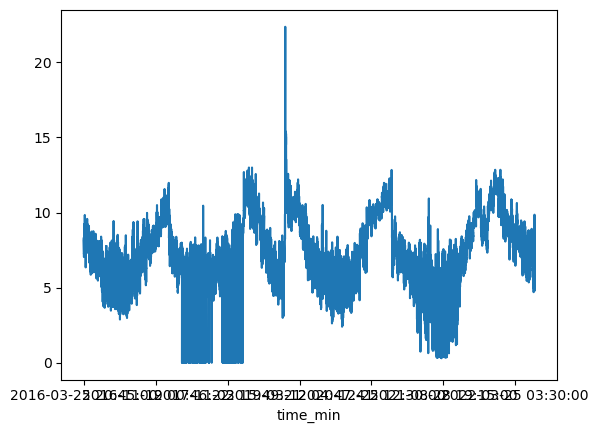

In [79]:
data_W["ODO"].plot()
plt.show()

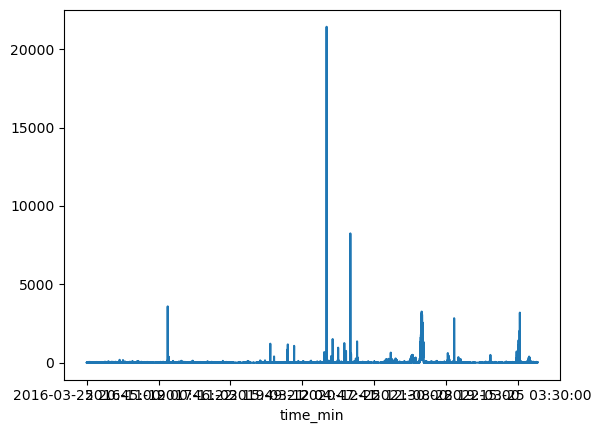

In [80]:
data_W["turbidity"].plot()
plt.show()

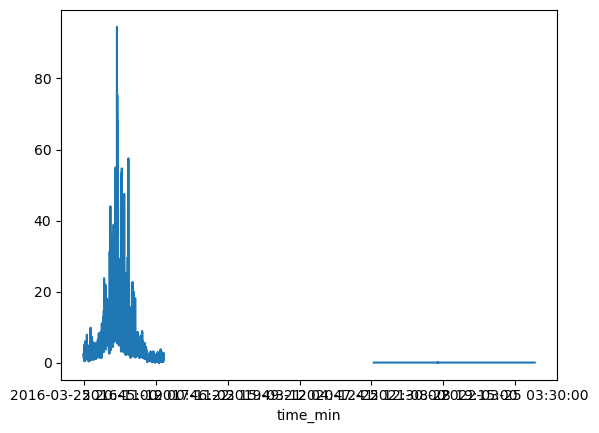

In [81]:
data_W["chlorophyll"].plot()
plt.show()


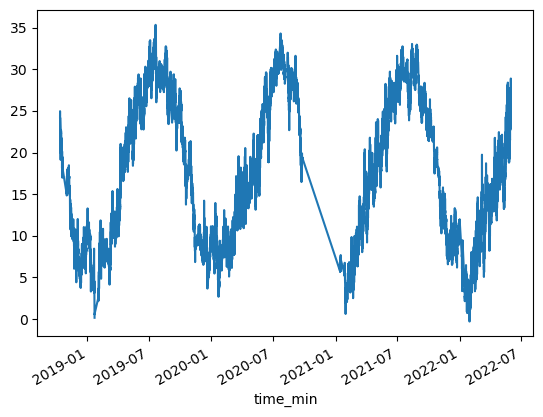

In [82]:
data_WW["temperature"].plot()
plt.show()

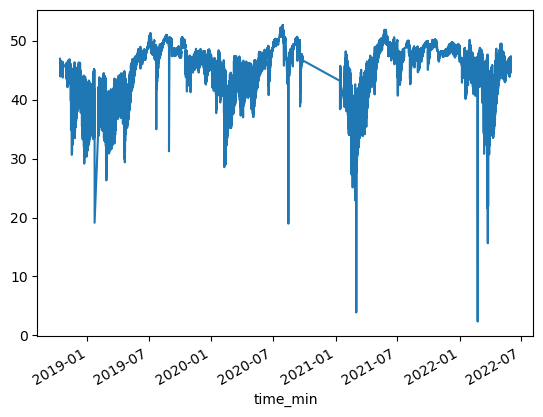

In [83]:
data_WW["conductivity"].plot()
plt.show()

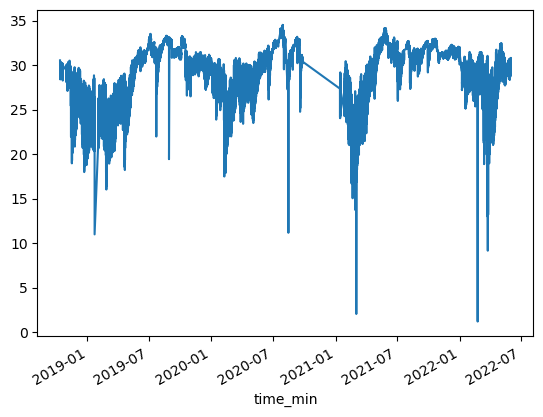

In [84]:
data_WW["salinity"].plot()
plt.show()

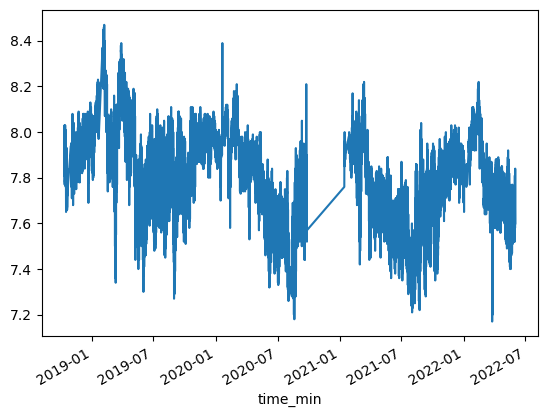

In [85]:
data_WW["pH"].plot()
plt.show()

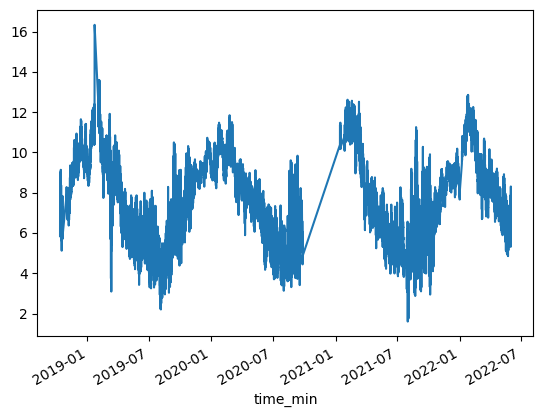

In [86]:
data_WW["ODO"].plot()
plt.show()

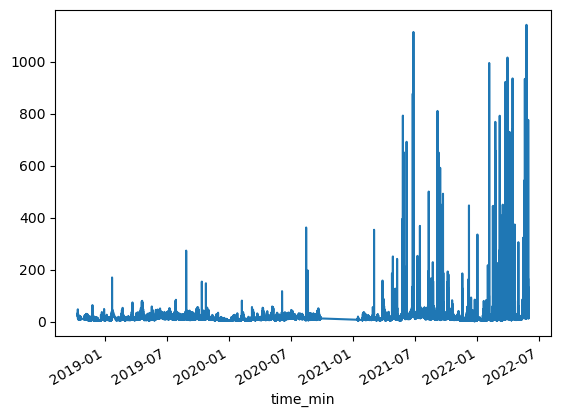

In [87]:
data_WW["turbidity"].plot()
plt.show()

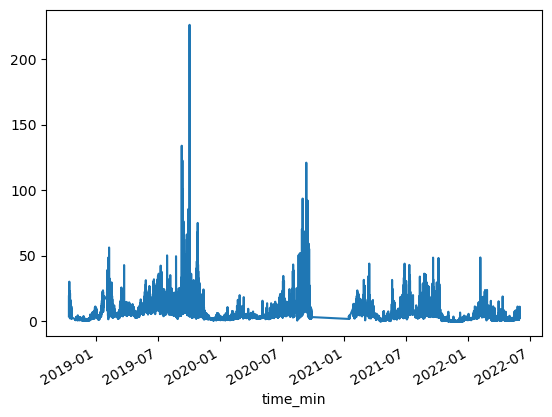

In [88]:
data_WW["chlorophyll"].plot()
plt.show()


## Model

### Functions

In [4]:
class MSLR():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None):
        self.n_components = n_components
        self.n_iter = n_iter
        self.covariance_type = covariance_type 
        self.tol = 0.0
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            print("Warning: no reg_method = % s, use LinearRegression" % reg_method)
            self.reg_method = LinearRegression
        
        return
    
    
    def fit_predict(self, X, Y, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        n_seq = len(list_X)
        list_T = [len(i) for i in list_X]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        K = self.n_components
        self.n_features = p
        
        self.transmat_ = np.array([[1. / K for j in range(K)] for i in range(K)])

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
            list_list_log_emission = [[np.copy(list_cur_mat_log_b[index_X][i, :]) for i in range(T)] for index_X, T in enumerate(list_T)]
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(self.transmat_), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(self.transmat_[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(self.transmat_[ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self.transmat_ = self._calc_transmat(list_tmp_array3d_log_epsilon)
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol):
                break
            
            #print("epoch % s, loglik = % s" % (epoch, loglik))
            #print(cur_list_mvn_mean_cov)
            #print(cur_transmat)
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= np.max(tmp)
            tmp = np.exp(tmp)
            tmp /= np.sum(tmp)
            self.list_last_posterior[ii] = tmp
        
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = self.list_last_posterior[ii] @ self.transmat_
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_transmat(self, list_tmp_array3d_log_epsilon):
        K = self.n_components
        cur_transmat = np.zeros((K, K)) 
        for ii in range(K):
            tmp_list_log_prob = []
            for jj in range(K):
                tmp_log_prob = []
                for index_X in range(len(list_tmp_array3d_log_epsilon)):
                    tmp_log_prob.append(logsumexp(list_tmp_array3d_log_epsilon[index_X][:, ii, jj]))
                tmp_list_log_prob.append(logsumexp(tmp_log_prob))
            tmp_list_log_prob = np.array(tmp_list_log_prob)
            tmp_list_log_prob -= np.max(tmp_list_log_prob)
            tmp_prob = np.exp(tmp_list_log_prob)
            tmp_prob /= sum(tmp_prob)
            cur_transmat[ii, :] = tmp_prob
        return cur_transmat
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
# def _test_MSLR():
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     T = 10000
    
#     list_X, list_Y = [], []
#     list_X_test = []
#     for ii in range(5):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, 3))
#         X_test = np.random.normal(loc=1.0, scale=5.0, size=(1, 3))
#         Y, list_h_label = [], []
#         for tt in range(T):
#             if tt == 0:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = init_prob, size = 1))
#             else:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = transmat[tmp_h_label], size = 1))
#             list_h_label.append(tmp_h_label)
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_X_test.append(X_test)
        
#     mslr = MSLR(n_components=3, covariance_type="full", n_iter=10)
#     pred = mslr.fit_predict(list_X, list_Y, list_X_test, is_multiple_sequence=True)
#     print(pred)
#     print(mslr.transmat_)
#     print(mslr.startprob_)
#     for tmp_lr, tmp_cov in mslr.list_lr_cov:
#         print(tmp_lr.coef_)
#         print(tmp_lr.intercept_)
#         print(tmp_cov)

#     return


# _test_MSLR()


In [5]:
class MSLRX():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None, 
                 is_logistic_regression_CV = False, logistic_regression_C = 1e10, is_logistic_regression_standardized = False,
                is_state_coef_indep = False, is_ordinal_logit = False, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.is_logistic_regression_CV = is_logistic_regression_CV
        self.logistic_regression_C = logistic_regression_C
        self.is_state_coef_indep = is_state_coef_indep
        self.is_ordinal_logit = is_ordinal_logit    # only valid when the response is 1-dim so we could sort it
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            print("Warning: no reg_method = % s, use LinearRegression" % reg_method)
            self.reg_method = LinearRegression
        
        self.is_logistic_regression_standardized = is_logistic_regression_standardized
        if is_logistic_regression_standardized:
            self.standardizer = StandardScaler()
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    if self.is_state_coef_indep or self.is_ordinal_logit:
                        if self.is_initialized:
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            tmp_new_exog = [int(i == ii_index) for i in range(K)]
                            tmp_new_exog.extend(tmp_exog)
                            tmp_prob = self.logit_clf.predict_proba(np.array([tmp_new_exog]))[0]
                            if self.is_ordinal_logit:
                                tmp_prob = tmp_prob[self.list_sorted_index_to_original_index]
                            
                        else:
                            tmp_prob = [1 / K for i in range(K)]
                    else:
                        tmp_log_prob = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                        tmp_log_prob -= np.max(tmp_log_prob)
                        tmp_prob = np.exp(tmp_log_prob)
                        tmp_prob /= np.sum(tmp_prob)
                    tmp_trans_mat.append(tmp_prob)
                list_trans_mat.append(tmp_trans_mat)
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        if self.is_ordinal_logit:
            self.list_sorted_index = np.argsort([i[0] for i, j in self.list_mvn_mean_cov])
            self.list_sorted_index_to_original_index = [i for i, j in sorted(list(enumerate(self.list_sorted_index)), key = lambda x: x[1])]
            #print(self.list_mvn_mean_cov)
            #print([i[0] for i, j in self.list_mvn_mean_cov])
            #print(self.list_sorted_index, self.list_sorted_index_to_original_index)
        
        if self.is_state_coef_indep or self.is_ordinal_logit:
            K = self.n_components
            if self.is_ordinal_logit:
                logit_clf = mord.LogisticAT(alpha = 1 / self.logistic_regression_C, verbose = 0, max_iter = 100)
            else:
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            
            for ii in range(K):
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            jj_index = self.list_sorted_index[jj] if self.is_ordinal_logit else jj
                            
                            tmp_exog = [int(i == ii_index) for i in range(K)]
                            tmp_exog.extend(exog[tt])
                            
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(tmp_exog)
                                tmp_y_nan.append(jj_index)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(tmp_exog)
                                tmp_y.append(jj_index)
                                tmp_weight.append(tmp_weight_cell)
            
            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X.extend(tmp_X_nan)
                    tmp_y.extend(tmp_y_nan)
                    tmp_weight.extend([1 / K for i in range(len(tmp_weight_nan))])

            logit_clf.fit(np.array(tmp_X), np.array(tmp_y), np.array(tmp_weight)) 
            self.logit_clf = logit_clf
            
        else:
            K = self.n_components
            self.list_coef_, self.list_intercept_ = [], []
            for ii in range(K):
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                tmp_X, tmp_y, tmp_weight = [], [], []
                tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(exog[tt])
                                tmp_y_nan.append(jj)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(exog[tt])
                                tmp_y.append(jj)
                                tmp_weight.append(tmp_weight_cell)

                if len(tmp_y_nan) >= 1: 
                    print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                    if len(set(tmp_y)) < K:
                        tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                        tmp_weight = 1

                logit_clf.fit(tmp_X, tmp_y, tmp_weight)

                if self.n_components == 2:
                    tmp_coef = np.array([- logit_clf.coef_.flatten(), logit_clf.coef_.flatten()])
                    tmp_intercept = np.array([- logit_clf.intercept_[0], logit_clf.intercept_[0]])
                else:
                    tmp_coef = logit_clf.coef_[np.argsort(logit_clf.classes_), :]
                    tmp_intercept = logit_clf.intercept_[np.argsort(logit_clf.classes_)]
                self.list_coef_.append(np.transpose(tmp_coef))
                self.list_intercept_.append(tmp_intercept)
                
        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            
        if self.is_logistic_regression_standardized:
            self.standardizer.fit(np.concatenate(list_exog))
            list_exog = [self.standardizer.transform(i, copy=True) for i in list_exog]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = (p_exog, K)) for i in range(K)]
        self.list_intercept_ = [np.zeros(shape = K) for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            self.list_log_pred_posterior.append(matmul_log(np.transpose(list_cur_list_trans_mat[ii][-1]), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
            
        if self.is_logistic_regression_standardized:
            list_exog_test = [self.standardizer.transform(i, copy=True) for i in list_exog_test]
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRX():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRX()")
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(10):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRX(n_components=3, covariance_type="full", n_iter=10, is_logistic_regression_standardized = True)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRX()


In [6]:
class MSLRXSoluIII():
    
    def __init__(self, n_components = 2, covariance_type="full", reg_method = "OLS", kargs_reg = None, n_iter = 10, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            print("Warning: no reg_method = % s, use LinearRegression" % reg_method)
            self.reg_method = LinearRegression
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    tmp_prob_1 = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                    tmp_prob_1 = max(min(tmp_prob_1, 1 - 1e-5), 1e-5)
                    tmp_prob_0 = 1 - tmp_prob_1
                    tmp_trans_mat.append([tmp_prob_0, tmp_prob_1])
                list_trans_mat.append(np.array(tmp_trans_mat))
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        K = self.n_components
        self.list_coef_, self.list_intercept_ = [], []
        for ii in range(K):
            
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                T = len(array3d_log_epsilon)
                for tt in range(T):
                    for jj in range(K):
                        tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                        if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                            tmp_X_nan.append(exog[tt])
                            tmp_y_nan.append(jj)
                            tmp_weight_nan.append(tmp_weight_cell)
                        else:
                            tmp_X.append(exog[tt])
                            tmp_y.append(jj)
                            tmp_weight.append(tmp_weight_cell)

            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                    tmp_weight = 1
            
            tmp_X = sm.add_constant(tmp_X, has_constant='add', prepend=True)
            res_glm = sm.GLM(exog = tmp_X, endog = tmp_y, family=sm.families.Binomial(link = sm.families.links.identity()), freq_weights = tmp_weight).fit()
            
            tmp_intercept = res_glm.params[0]
            tmp_coef = np.array(res_glm.params[1:])
            
            self.list_coef_.append(tmp_coef) 
            self.list_intercept_.append(tmp_intercept)

        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = p_exog) for i in range(K)]
        self.list_intercept_ = [1 / K for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            self.list_log_pred_posterior.append(matmul_log(np.transpose(list_cur_list_trans_mat[ii][-1]), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRXSoluIII():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRXSoluIII()")
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.1], [ 0.3, 0.7]])
#     init_prob = np.array([1 / 3, 2 / 3])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(100):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRXSoluIII(n_components=2, covariance_type="full", n_iter=10)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRXSoluIII()


### MSLR-X

In [7]:
data_WW = data_WW.dropna()
data_WW_byday = data_WW[["date", "conductivity", "salinity", "ODO", "turbidity", "chlorophyll"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()

array_obs = data_WW_byday["chlorophyll"].to_numpy()
array_datetime = data_WW_byday["date"].to_numpy()
#array_cross = data_WW[["conductivity", "salinity", "ODO", "turbidity", "temperature", "pH"]].to_numpy()
#array_cross = data_WW[["conductivity", "salinity", "ODO", "turbidity", "pH"]].to_numpy()
#array_cross = data_WW_byday[["salinity", "ODO", "turbidity", "pH"]].to_numpy()
array_cross = data_WW_byday[["salinity", "ODO", "turbidity", "pH", "temperature"]].to_numpy()

In [8]:
#reg_method = "LinearRegression"
#reg_method = "RidgeCV"
reg_method = "LinearSVR"

reg_method_func = LinearSVR
#reg_method_func = LinearRegression
#reg_method_func = RidgeCV

kargs_reg = {"random_state": 35}
#kargs_reg = None


In [9]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 21:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

# list_split_index = list(np.where(np.isnan(array_obs))[0])
# list_split_index.append(len(array_obs))
# list_split_index.insert(0, 0)
# list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
# for tmp_index in range(len(list_split_index) - 1):
#     tmp_index_left = list_split_index[tmp_index] + 1
#     tmp_index_right = list_split_index[tmp_index + 1]
#     while tmp_index_right - tmp_index_left > 20:
#         tmp_index_next = min(tmp_index_left + 40, tmp_index_right)
#         list_subseq.append(array_obs[tmp_index_left:tmp_index_next])
#         list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_next])
#         list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_next])
#         tmp_index_left = tmp_index_next
    

In [10]:
[len(i) for i in list_subseq]

[84,
 52,
 91,
 34,
 108,
 86,
 43,
 109,
 23,
 41,
 21,
 90,
 22,
 35,
 56,
 65,
 72,
 118,
 128]

In [11]:
list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
    X, Y, exog = [], [], []
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
        tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [12]:
start_time = datetime.datetime.now()

list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
list_y_pred_mslrxsolu3 = []
for cc in range(4, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    tmp_list_y_pred_mslrxsolu3 = []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                      logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
    list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
    
    print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
    
    #if cc > 5: break
        

seq 4 finished 0:11:00.683807
seq 5 finished 0:18:54.768814
seq 6 finished 0:22:28.649509
seq 7 finished 0:33:08.675729
seq 8 finished 0:34:50.907202
seq 9 finished 0:38:39.590356
seq 10 finished 0:40:23.067088
seq 11 finished 0:51:50.055795
seq 12 finished 0:53:59.500576
seq 13 finished 0:57:58.281825
seq 14 finished 1:05:12.529660
seq 15 finished 1:15:09.334536
seq 16 finished 1:26:28.920841
seq 17 finished 1:47:04.399200
seq 18 finished 2:09:26.994210


In [13]:
thres = 10.0

list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_res_logitcos_cross = []
for start_index in range(7, 20):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross) in enumerate(zip(list_subseq, list_subseq_datetime, list_subseq_cross)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_date).replace(month = 1, day = 1).toordinal()
            #tmp_X.append(np.cos(tmp_t / 365 * 2 * np.pi))
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            for tmp_p in list_p_AR_cross:
                tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
            X.append(tmp_X)
            #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= 4 and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = reg_method_func(**kargs_reg)
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    tmp_r2_ar, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
    tmp_rocauc_ar, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("AR", tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrx, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
    tmp_rocauc_mslrx, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MSLRX", tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrxsolu3[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrxsolu3, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
    tmp_rocauc_mslrxsolu3, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MXLRXSolu3", tmp_r2_mslrxsolu3, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
      
    tmp_r2_mslr, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
    tmp_rocauc_mslr, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MSLR", tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitcos_cross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
                                    tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive))
    
    

7
AR 0.23666866751351445 0.15199598311873685 0.9198695494624956 0.9588235294117646
MSLRX 0.29034858598139246 0.15199598311873685 0.9164343519748762 0.9588235294117646
MXLRXSolu3 0.29871129887390657 0.15199598311873685 0.9236236260417925 0.9588235294117646
MSLR 0.2802712094303379 0.15199598311873685 0.9208020292305834 0.9588235294117646
8
AR 0.235037705266414 0.14119289841287752 0.9214428457234213 0.9587005395683452
MSLRX 0.2853609467509435 0.14119289841287752 0.9159622302158272 0.9587005395683452
MXLRXSolu3 0.29274470325087365 0.14119289841287752 0.9228567146282973 0.9587005395683452
MSLR 0.27572351569828835 0.14119289841287752 0.9224620303756994 0.9587005395683452
9
AR 0.23015021966059146 0.1376588225596549 0.9233464241422077 0.9584694088466308
MSLRX 0.28110331234974895 0.1376588225596549 0.9174658949979331 0.9584694088466308
MXLRXSolu3 0.2869948634857925 0.1376588225596549 0.9238631665977677 0.9584694088466308
MSLR 0.2699853613643065 0.1376588225596549 0.9222819346837535 0.9584694088

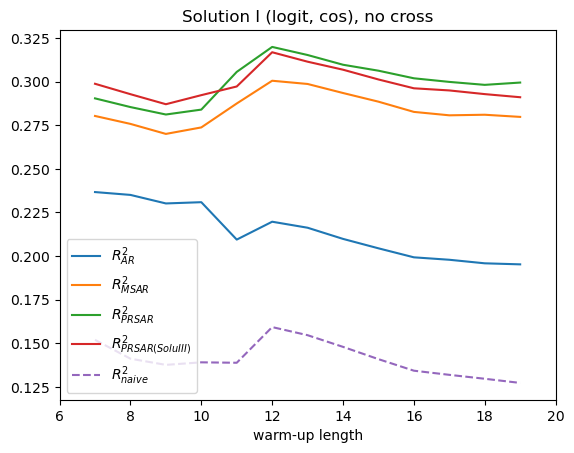

In [14]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx, list_y_mslrxsolu3 = [], [], [], [], []
list_y_naive = []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
                                    tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar)
    list_y_mslr.append(tmp_r2_mslr)
    list_y_mslrx.append(tmp_r2_mslrx)
    list_y_mslrxsolu3.append(tmp_r2_mslrxsolu3)
    list_y_naive.append(tmp_r2_naive)

plt.plot(list_x, list_y_ar, label = r'$R^2_{AR}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR}$')
plt.plot(list_x, list_y_mslrxsolu3, label = r'$R^2_{PRSAR (SoluIII)}$')
plt.plot(list_x, list_y_naive, "--", label = r'$R^2_{naive}$')

plt.legend()
plt.xlim(6, 20)
plt.xlabel("warm-up length")
plt.title("Linear SVM")
plt.show()
    

### MSLR-X (Solution III)

In [8]:
data_WW = data_WW.dropna()
data_WW_byday = data_WW[["date", "conductivity", "salinity", "ODO", "turbidity", "chlorophyll"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()

array_obs = data_WW_byday["chlorophyll"].to_numpy()
array_datetime = data_WW_byday["date"].to_numpy()
#array_cross = data_WW[["conductivity", "salinity", "ODO", "turbidity", "temperature", "pH"]].to_numpy()
#array_cross = data_WW[["conductivity", "salinity", "ODO", "turbidity", "pH"]].to_numpy()
array_cross = data_WW_byday[["salinity", "ODO", "turbidity", "pH"]].to_numpy()

In [18]:
#reg_method = LinearRegression
#reg_method = RidgeCV
reg_method = LinearSVR

In [19]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 40:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

# list_split_index = list(np.where(np.isnan(array_obs))[0])
# list_split_index.append(len(array_obs))
# list_split_index.insert(0, 0)
# list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
# for tmp_index in range(len(list_split_index) - 1):
#     tmp_index_left = list_split_index[tmp_index] + 1
#     tmp_index_right = list_split_index[tmp_index + 1]
#     while tmp_index_right - tmp_index_left > 20:
#         tmp_index_next = min(tmp_index_left + 40, tmp_index_right)
#         list_subseq.append(array_obs[tmp_index_left:tmp_index_next])
#         list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_next])
#         list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_next])
#         tmp_index_left = tmp_index_next
    

In [20]:
[len(i) for i in list_subseq]

[84, 52, 91, 108, 86, 43, 109, 41, 90, 56, 65, 72, 118, 128]

In [21]:
list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
    X, Y, exog = [], [], []
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
        tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [22]:
start_time = datetime.datetime.now()

list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
for cc in range(4, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10)
        mslrx.reg_method = reg_method
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10)
        mslr.reg_method = reg_method
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
    
    print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))


seq 4 finished 0:04:13.916997
seq 5 finished 0:06:25.963000
seq 6 finished 0:13:29.818998
seq 7 finished 0:16:04.053999
seq 8 finished 0:22:43.583997
seq 9 finished 0:27:20.511822
seq 10 finished 0:33:35.824247
seq 11 finished 0:42:01.228611
seq 12 finished 0:57:41.332722
seq 13 finished 1:17:54.821440


In [23]:
thres = 2.0

list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_res_logitcos_cross = []
for start_index in range(7, 30):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross) in enumerate(zip(list_subseq, list_subseq_datetime, list_subseq_cross)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_date).replace(month = 1, day = 1).toordinal()
            tmp_X.append(np.cos(tmp_t / 365 * 2 * np.pi))
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            for tmp_p in list_p_AR_cross:
                tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
            X.append(tmp_X)
            #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= 4 and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = reg_method()
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
      
    tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitcos_cross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive))
    
    

7
-0.10777770240123519 -0.06789350646153158 0.9061349361056963 0.965616200996318
0.05998040026087503 -0.06789350646153158 0.9011804201862682 0.965616200996318
-0.03612175249926075 -0.06789350646153158 0.9091672081438164 0.965616200996318
8
-0.13666823004751838 -0.06882028426179265 0.9082320055904961 0.9665129280223619
0.05998108756097087 -0.06882028426179265 0.9033123689727464 0.9665129280223619
-0.033063160689082105 -0.06882028426179265 0.9104961565338924 0.9665129280223619
9
-0.15606006210582657 -0.0699033894158172 0.9113825363825364 0.9656675906675907
0.0622176938555542 -0.0699033894158172 0.9029799029799029 0.9656675906675907
-0.031995187430498895 -0.0699033894158172 0.9085239085239086 0.9656675906675907
10
-0.10583523232667447 -0.07105605313008656 0.8756677709135404 0.9647237890590027
0.06139614140096572 -0.07105605313008656 0.9030053421673083 0.9647237890590027
-0.03269602129050453 -0.07105605313008656 0.9079296863341988 0.9647237890590027
11
-0.06605347238578241 -0.0780800862121

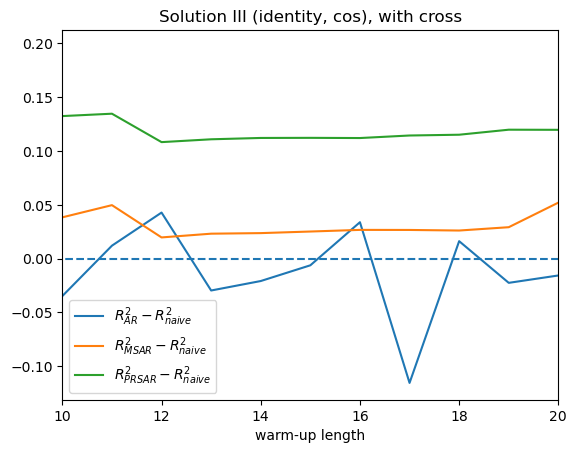

In [24]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar - tmp_r2_naive)
    list_y_mslr.append(tmp_r2_mslr - tmp_r2_naive)
    list_y_mslrx.append(tmp_r2_mslrx - tmp_r2_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$R^2_{AR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR} - R^2_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution III (identity, cos), with cross")
plt.show()
    

In [88]:
# roc-auc
# list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
# for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
#     len_warmup = cc + 7
#     list_x.append(len_warmup)
#     list_y_ar.append(tmp_rocauc_ar - tmp_rocauc_naive)
#     list_y_mslr.append(tmp_rocauc_mslr - tmp_rocauc_naive)
#     list_y_mslrx.append(tmp_rocauc_mslrx - tmp_rocauc_naive)
    
# plt.hlines(0.0, 0, 100, linestyles = "--")
# plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR} - ROCAUC_{naive}$')
# plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR} - ROCAUC_{naive}$')
# plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR} - ROCAUC_{naive}$')
# plt.legend()
# plt.xlim(10, 20)
# plt.xlabel("warm-up length")
# plt.title("Solution I (logit, cos), no cross")
# plt.show()
    

## End of notebook